<a href="https://colab.research.google.com/github/Mohamadaminlotfi98/Spike-Sorting-with-Diffrent-deep-learning-models/blob/main/1_DCNN_spike_sorting_waveforms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)
%cd /gdrive/MyDrive

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchsummary import summary

In [ ]:
!pip install pymatreader

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from pymatreader import read_mat
data = read_mat('Spike/artificial_data_snoise_0.5_seed_0.mat')

In [ ]:
spike_class = data['truth']['neuronTags']
signal_data = data['signal']['data']
dt = data['signal']['dt']
spike_times = np.round(data['truth']['timeStamps'] / dt).astype(int)
num_spike = len(spike_times)
num_sample_forward = 50
num_sample_backward = 30
spike_curve = np.zeros((num_spike, num_sample_forward - num_sample_backward))

# Extract the spike curves
for i in range(num_spike):
    spike_curve[i] = signal_data[(spike_times[i] + num_sample_backward):(spike_times[i] + num_sample_forward)]

Text(0, 0.5, 'uV')

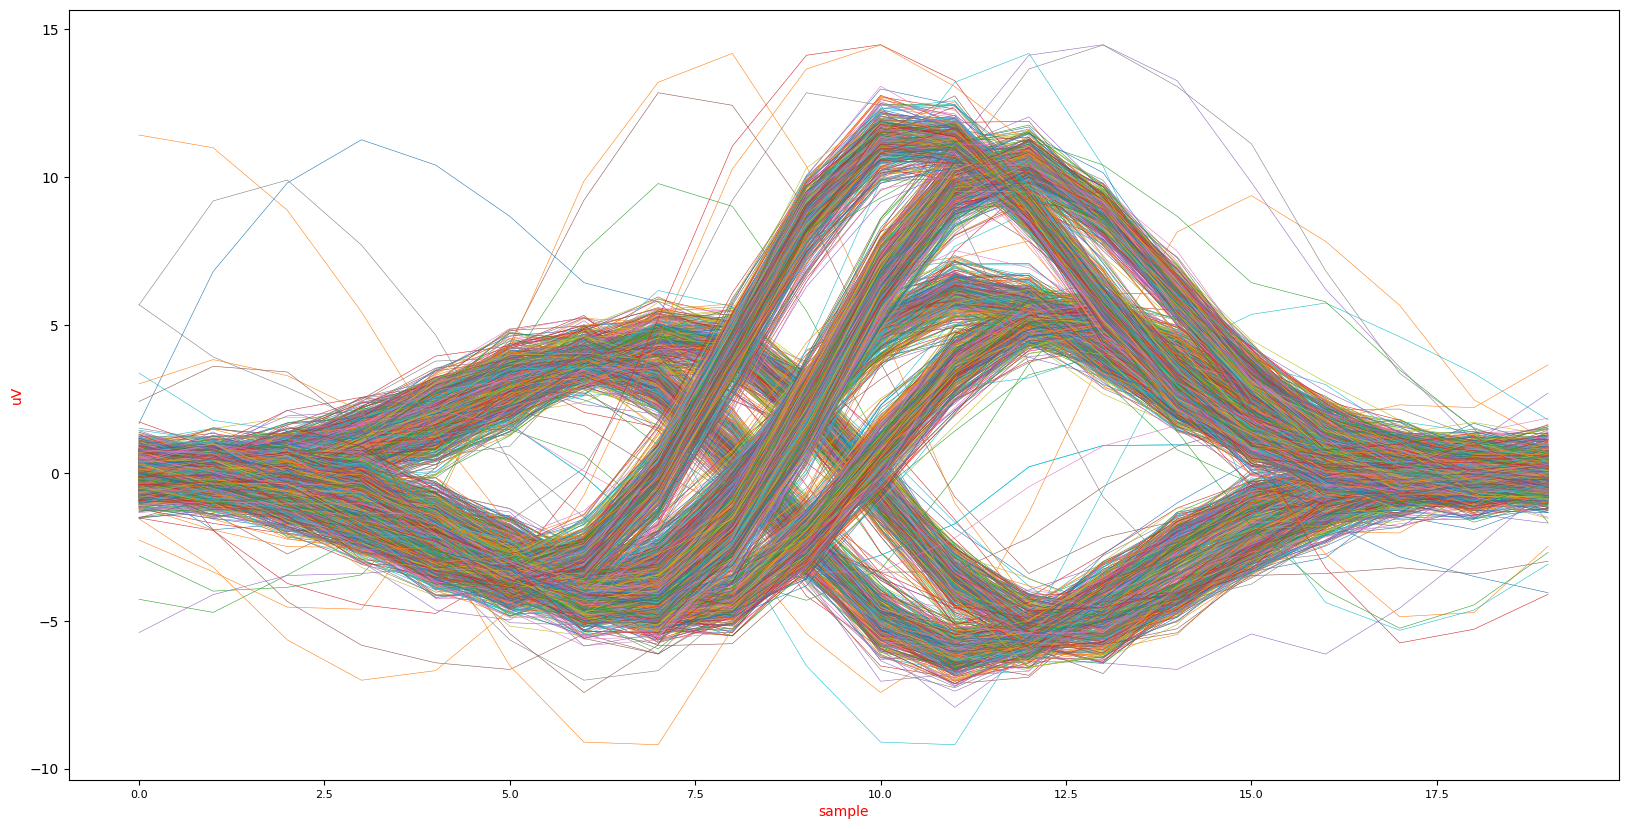

In [ ]:
plt.figure(figsize=(20,10))
for i in range(num_spike):
    plt.plot(spike_curve[i],linewidth=0.4)
plt.xticks(fontsize=8)
plt.xlabel('sample',color='red')
plt.ylabel('uV',color='red')

In [ ]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()

        # Define the convolutional layers
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3, stride=1)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, stride=1)
        self.conv3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, stride=1)

        # Define the max pooling layer
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)

        # Define the fully connected layers
        self.fc1 = nn.Linear(128, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 3)


    def forward(self, x):
        # Pass the input signal through the convolutional layers
        x = self.pool(torch.relu((self.conv1(x))))
        x = self.pool(torch.relu((self.conv2(x))))
        x = self.pool(torch.relu((self.conv3(x))))
        # Flatten the output of the convolutional layers
        x = x.view(-1, 128 * 1)
        # Pass the flattened output through the fully connected layers
        x = torch.relu((self.fc1(x)))
        x = torch.relu((self.fc2(x)))
        x = (self.fc3(x))

        return x


In [ ]:
# Define your execution device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = ConvNet()
print("The model will be running on", device, "device\n")
model.to(device)    # Convert model parameters and buffers to CPU or Cuda
#summary(model, (1,45))

The model will be running on cuda:0 device



ConvNet(
  (conv1): Conv1d(1, 32, kernel_size=(3,), stride=(1,))
  (conv2): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (conv3): Conv1d(64, 128, kernel_size=(3,), stride=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=128, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=3, bias=True)
)

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
# Load your data and labels
data = spike_curve
label = spike_class-1

X_train, test_data, X_label, test_label = train_test_split(data, label, test_size=0.50,shuffle = True)
train_data, val_data, train_label, val_label = train_test_split(X_train, X_label, test_size=0.05,shuffle = True)

# Convert the data and labels to PyTorch tensors
train_inputs = torch.from_numpy(train_data).float()
val_inputs = torch.from_numpy(val_data).float()
test_inputs = torch.from_numpy(test_data).float()

train_labels = torch.from_numpy(train_label).float()
val_labels = torch.from_numpy(val_label).float()
test_labels = torch.from_numpy(test_label).float()

In [ ]:
print(train_inputs.shape)
print(val_inputs.shape)
print(test_inputs.shape)
print(train_labels.shape)
print(val_labels.shape)
print(test_labels.shape)

torch.Size([958, 25])
torch.Size([51, 25])
torch.Size([1009, 25])
torch.Size([958])
torch.Size([51])
torch.Size([1009])


In [ ]:
num_epochs = 50

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

inputs = torch.tensor([])

# Train the network
for epoch in range(num_epochs):
  training_loss = 0
  loss_back = 0

  for i in range(0, train_inputs.size(0)):
    # Get the input and labels for the current batch
    inputs = train_inputs[i:i+1].to(device)
    labels = train_labels[i:i+1].to(device)

    # Forward pass

    outputs = model(inputs)
    loss = criterion(outputs, labels.long())
    training_loss += loss
    loss_back += loss

    # Zero the gradients
    if i % 100 == 0:
        optimizer.zero_grad()

        # Backward pass and optimization
        loss_back.backward()
        optimizer.step()
        loss_back = 0

  training_loss = training_loss/train_inputs.size(0)
  print('******************************************************************')
  print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, training_loss))

  with torch.no_grad():
    correct = 0
    val_loss = 0

    for j in range(0,val_inputs.size(0)):
      # Get the input and labels for the current batch
      inputs = val_inputs[j:j+1].to(device)
      labels = val_labels[j:j+1].to(device)
      outputs = model(inputs)
      loss = criterion(outputs, labels.long())

      val_loss += loss

      _, predicted = torch.max(outputs.data, 1)
      correct += (predicted == labels).sum().item()

    val_loss = val_loss/val_inputs.size(0)
    print('Validation Loss: {:.4f}'.format(val_loss))
    print('Validation Accuracy: {:.2f}% ({}/{})'.format(100*correct/val_inputs.size(0), correct, val_inputs.size(0)))

******************************************************************
Epoch [1/50], Loss: 0.9852
Validation Loss: 0.7772
Validation Accuracy: 66.67% (34/51)
******************************************************************
Epoch [2/50], Loss: 0.3990
Validation Loss: 0.1762
Validation Accuracy: 94.12% (48/51)
******************************************************************
Epoch [3/50], Loss: 0.2243
Validation Loss: 0.1532
Validation Accuracy: 92.16% (47/51)
******************************************************************
Epoch [4/50], Loss: 0.1821
Validation Loss: 0.1246
Validation Accuracy: 96.08% (49/51)
******************************************************************
Epoch [5/50], Loss: 0.1424
Validation Loss: 0.0713
Validation Accuracy: 98.04% (50/51)
******************************************************************
Epoch [6/50], Loss: 0.1186
Validation Loss: 0.0603
Validation Accuracy: 96.08% (49/51)
******************************************************************
Epoch [7/

In [ ]:
model.eval()

dataset = ['0.5','0.75','1','1.25','1.5','1.75','2']
for read in dataset:

  data = read_mat('Spike/artificial_data_snoise_'+read+'_seed_0.mat')
  spike_class = data['truth']['neuronTags']
  signal_data = data['signal']['data']
  dt = data['signal']['dt']
  spike_times = np.round(data['truth']['timeStamps'] / dt).astype(int)
  idx_spike=spike_times
  num_spike=len(spike_times)
  num_sample_forward=50
  num_sample_backward=25
  spike_curve=np.zeros((num_spike,num_sample_forward-num_sample_backward))
  for i in range(num_spike):
      spike_curve[i]=signal_data[(idx_spike[i]+num_sample_backward):(idx_spike[i]+num_sample_forward)]
  label = spike_class-1
  data = spike_curve
  # Convert the data and labels to PyTorch tensors
  test_inputs = torch.from_numpy(data).float()
  test_labels = torch.from_numpy(label).float()
  # Put the model in evaluation mode
  # Define variables for tracking accuracy and loss
  test_loss = 0
  correct = 0
  total = 0
  # Lists to store wrong predictions
  wrong_inputs = []
  wrong_predicted = []
  wrong_labels = []
  wrong_denoised_outputs = []
  # Loop over the test dataset
  with torch.no_grad():
      for i in range(len(test_inputs)):
          # Get inputs and labels from the test dataset
          inputs = test_inputs[i:i+1].to(device)
          labels = test_labels[i:i+1].long().to(device)
          # Forward pass
          outputs = model(inputs)
          test_loss += criterion(outputs, labels).item()
          # Compute accuracy
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
          # print('True label:',labels,'Prediction is:',predicted)
            # Check for wrong predictions
  # Compute average test loss and accuracy
  test_loss /= len(test_data)
  test_acc = 100 * correct / total
  # Print results
  print('*****************')
  print("Noise:",read)
  print('Test Accuracy: {:.2f}% ({}/{})'.format(100*correct/test_inputs.size(0) , correct, test_inputs.size(0)),"loss:",test_loss)
  # Plot wrong predictions with denoised output
  # fig, axs = plt.subplots(len(wrong_inputs), 2, figsize=(8, 2*len(wrong_inputs)))
  # for i in range(len(wrong_inputs)):
  #     axs[i, 0].plot(wrong_inputs[i][0])
  #     axs[i, 0].set_title(f"True: {wrong_labels[i]}, Predicted: {wrong_predicted[i]}")
  #     axs[i, 0].axis('off')
  #     axs[i, 1].plot(wrong_denoised_outputs[i][0])
  #     axs[i, 1].set_title('Denoised Output')
  #     axs[i, 1].axis('off')
  # plt.show()

*****************
Noise: 0.5
Test Accuracy: 99.55% (2009/2018) loss: 0.05658176817527627
*****************
Noise: 0.75
Test Accuracy: 98.86% (1995/2018) loss: 0.09325673407796693
*****************
Noise: 1
Test Accuracy: 96.58% (1949/2018) loss: 0.2301407600892326
*****************
Noise: 1.25
Test Accuracy: 93.66% (1890/2018) loss: 0.46964017202084585
*****************
Noise: 1.5
Test Accuracy: 90.73% (1831/2018) loss: 0.7899732341709816
*****************
Noise: 1.75
Test Accuracy: 87.46% (1765/2018) loss: 1.1987987139947582
*****************
Noise: 2
Test Accuracy: 84.34% (1702/2018) loss: 1.6836627820416765


In [ ]:
!

In [ ]:
#@title Default title text
  num_epochs = 15
  #best_val_loss = float('inf')
  #weights_path = 'path/to/weights.pth'
  # Load the weights for the model
  #if os.path.isfile(weights_path):
  #    checkpoint = torch.load(weights_path)
  #    model.load_state_dict(checkpoint['state_dict'])
  #    print("Model loaded from", weights_path)
  #else:
  #    print("No model found in", weights_path)
  # Define the loss function and optimizer
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=0.001)

  inputs = torch.tensor([])
  # Train the network
  for epoch in range(num_epochs):
    training_loss = 0
  loss_back = 0
  for i in range(0, train_inputs.size(0)):
    # Get the input and labels for the current batch
    inputs = train_inputs[i:i+1].to(device)
    labels = train_labels[i:i+1].to(device)
    # Forward pass
    outputs = model(inputs)
    loss = criterion(outputs, labels.long()-1)
    training_loss += loss
    loss_back += loss
    # Zero the gradients
    if i%20 == 0:
      optimizer.zero_grad()
      # Backward pass and optimization
      loss_back.backward()
      optimizer.step()
      loss_back = 0
  print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, training_loss))
  with torch.no_grad():
          correct = 0
          val_loss = 0
          for j in range(0,val_inputs.size(0)):
            # Get the input and labels for the current batch
            inputs = val_inputs[j:j+1].to(device)
            labels = val_labels[j:j+1].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels.long()-1)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted+1 == labels).sum().item()
            val_loss += loss
          #avg_val_loss = val_loss / val_inputs.size(0)
          #if avg_val_loss < best_val_loss:
            #best_val_loss = avg_val_loss
            #torch.save({'epoch': epoch, 'state_dict': model.state_dict(),'best_val_loss': best_val_loss,'optimizer' : optimizer.state_dict(),}
                           #, 'path/to/weights.pth')
          print('Validation Loss: {:.4f}'.format(val_loss))
          print('Validation Accuracy: {:.2f}% ({}/{})'.format(100*correct/val_inputs.size(0), correct, val_inputs.size(0)))


IndentationError: ignored

In [ ]:
Noise =['C_Easy1_noise005.mat','C_Easy1_noise01.mat','C_Easy1_noise015.mat','C_Easy1_noise02.mat','C_Easy1_noise025.mat',
        'C_Easy1_noise03.mat','C_Easy1_noise035.mat','C_Easy1_noise04.mat','C_Easy2_noise005.mat','C_Easy2_noise01.mat','C_Easy2_noise015.mat','C_Easy2_noise02.mat',
        'C_Difficult1_noise005.mat','C_Difficult1_noise01.mat','C_Difficult1_noise015.mat','C_Difficult1_noise02.mat',
        'C_Difficult2_noise005.mat','C_Difficult2_noise01.mat','C_Difficult2_noise015.mat','C_Difficult2_noise02.mat']

for d in Noise:
  data = read_mat('Simulator/'+ d)
  spike_class = data['spike_class'][0][:]
  spike_data = data['data']
  spike_times = data['spike_times']
  idx_spike=spike_times
  num_spike=len(spike_times)
  num_sample_forward=50
  num_sample_backward=5
  spike_curve=np.zeros((num_spike,num_sample_forward-num_sample_backward))
  for i in range(num_spike):
    spike_curve[i]=spike_data[(idx_spike[i]+num_sample_backward):(idx_spike[i]+num_sample_forward)]

  # Load your data and labels
  data = spike_curve
  label = spike_class

  X_train, test_data, X_label, test_label = train_test_split(data, label, test_size=0.20,shuffle = True)
  train_data, val_data, train_label, val_label = train_test_split(X_train, X_label, test_size=0.10,shuffle = True)

  # Convert the data and labels to PyTorch tensors
  train_inputs = torch.from_numpy(train_data).float()
  val_inputs = torch.from_numpy(val_data).float()
  test_inputs = torch.from_numpy(test_data).float()

  train_labels = torch.from_numpy(train_label).float()
  val_labels = torch.from_numpy(val_label).float()
  test_labels = torch.from_numpy(test_label).float()

  with torch.no_grad():
    test_loss = 0
    correct = 0
    total = 0
    for i in range(0, test_inputs.size(0)):
        # Get the input and labels for the current batch
        inputs = test_inputs[i:i+1].to(device)
        labels = test_labels[i:i+1].to(device)
        outputs = model(inputs)
        # Get the predictions
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted+1 == labels).sum().item()
        loss = criterion(outputs, labels.long()-1)
        test_loss += loss
  print('data:',d)
  print('Test Loss: {:.4f}'.format(test_loss))
  print('Test Accuracy: {:.2f}% ({}/{})'.format(100*correct/test_inputs.size(0), correct, test_inputs.size(0)))
